<p align="center">
    <img src="https://github.com/jessepisel/energy_analytics/blob/master/EA_logo.jpg?raw=true" width="220" height="240" />

</p>

# Final Project - Hingle Basin

## Freshman Research Initiative Energy Analytics CS 309

#### Written by: Denzell Ford, Harsh Kumar, Nicholas Khami, Rahul Shanmugham


To start, we import all of the packages that we will need in this notebook. 

In [1]:
import glob
import pandas as pd
import numpy as np
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from yellowbrick.regressor import ResidualsPlot
import copy
import requests
import sqlite3

# Stage 1: Preprocess The data

### Adding the features we will need to optimize to a DataFrame and then exporting to a csv

Here we read in the well production.csv file 

In [2]:
well_productions = pd.read_csv("well productions/well production.csv")

Here we read in the csv file for each well 

In [3]:
import csv
datas = []
for file in glob.glob("well productions/*"):
    if "well production.csv" not in file:
        frame = pd.read_csv(file)
        # Strip off the extra things on the end
        frame["Name"] = file[17:-4]
        datas.append(frame)

The following function calculates the well length for each well and adds the well length of each well to the DataFrame


In [4]:
def well_length(dataframe: pd.DataFrame):
    dataframe["well length"] = dataframe["easting"].iloc[-1] - dataframe["easting"][0]

The following function calculates the number of frac stages for each well and adds the calculated value to the DataFrame

In [5]:
def frac_stages(dataframe : pd.DataFrame):
    dataframe["frac stages"] = dataframe[dataframe["proppant weight (lbs)"].isna() == False].shape[0]

The following function sets proppant per stage as "ppf." It will default to the maximum weight. 

In [6]:
"""
Sets a proppant per stage as "ppf" defaults to the maximum weight
method can be ["min, "max", "avg"]
"""
def proppant_per_stage(dataframe: pd.DataFrame, method="max"):
    if method == "min":
        val = min(dataframe["proppant weight (lbs)"])
    elif method == "max":
        val = max(dataframe["proppant weight (lbs)"])
    elif method == "avg":
        val = dataframe["proppant weight (lbs)"].describe()["mean"]
    else:
        raise Exception(f"No method found for {method}")
    dataframe["ppf"] = val

The following function sets pump rate as "pr." It will default to the maximum rate. 

In [7]:
"""
Sets a pump rate as "pr" defaults to the maximum weight
method can be ["min, "max", "avg"]
"""
def pump_rate(dataframe: pd.DataFrame, method="max"):
    if method == "min":
        val = min(dataframe["pump rate (cubic feet/min)"])
    elif method == "max":
        val = max(dataframe["pump rate (cubic feet/min)"])
    elif method == "avg":
        val = dataframe["pump rate (cubic feet/min)"].describe()["mean"]
    else:
        raise Exception(f"No method found for {method}")
    dataframe["pr"] = val

The below function finds how many years the well will economically produce oil, under the assumption that up to 20 barrels of oil is economical. 

In [8]:
def life_of_res(qi, D):
    lifetime = 1/D*np.log(qi/20)
    if lifetime < 0:
        return 0
    else: 
        return lifetime

exponential loss curve

$ q(t) = q_ie^{-Dt} $

Where $D$ is the decline rate and $q_i$ is the initial rate of production
Exponential decline curve equation

    Arguments:
        t:  Number of months the well has been producing oil 
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        
    Output: 
        Returns q, or the expected production rate at time t. Float.

In [9]:
def exponential_loss(t, qi, D): 
    return qi*np.exp(-D*t)

 $ q(t) = \frac{q_i}{(1+bDt)^{1.0/b}} $
 
 Hyperbolic decline curve equation
 
    Arguments:
        t:  Number of months the well has been producing oil
        qi: Float. Initial production rate when well first came online.
        b:  Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
    Output: 
        Returns q, or the expected production rate at time t. Float.

In [10]:
def hyperbolic_loss(t, qi, b, di):
    return qi/((1.0+b*di*t)**(1.0/b))

This function allows you to look at the first X months of production, and selects the highest production month as max initial production. It returns the max initial production in the first X months along with a series that contains the values of oil production for the first 12 months. 
    
    Arguments:
        number_first_months: int. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        
        well_name: String. name of the well where we're attempting to get
        the max volume from.

In [11]:
def get_max_initial_production(number_first_months, well_name):
    
    row = well_productions.loc[well_productions["well name"] == well_name]
    val=0      
    row = row.filter(regex='oil')
    row=row.T.squeeze()
    
    for i in range(number_first_months):
        val = max(row[i], val)

    return val, row

The below two functions find the defined integral of the fitted exponential and hyperbolic equations between 0 and the calculated life of the reservoir. Our team found that was easier to use an integral then implement the equation fround in the "Hinge Basin" notebook. 

$ N_p = \int_0^{L_t} q(t)dt $ Where $N_p$ is total production and $L_t$ is the lifetime of the well

In [12]:
def get_cumulative_exponential(qi, D):
    return quad(exponential_loss, 0, life_of_res(qi, D), args=(qi,D))

def get_cumulative_hyperbolic(qi, b, di):
    return quad(hyperbolic_loss, 0, life_of_res(qi, di), args=(qi, b, di))

$N_{p} = (\frac{q_{i}}{D})ln(\frac{q_{i}}{q})$

In [13]:
def get_cumulative_other(qi, D, qt):
    t = life_of_res(qi, D)
    q = qt(t, qi, D) # for the exponential equation
    return (qi/D) * np.log(qi/q)

The following function will add the expected lifetime of the well when using the exponential_loss function and the hyperbolic function then add the respective values to the dataframe. Following that, it will find the cumulative production with the least amount of error out of the two functions, and add that value to the DataFrame. 

In [14]:
time_series=pd.Series(list(range(12)))
def cum_production(dataframe: pd.DataFrame, find_min=False):
    name = dataframe["Name"][0]
    qi, row = get_max_initial_production(5, name)
    
    popt_exp, pcov_exp = curve_fit(exponential_loss, time_series, row, bounds=(0, [qi,20]))
    popt_hyp, pcov_hyp=curve_fit(hyperbolic_loss, time_series, row,bounds=(0, [qi,2,20]))
    
    cp_exp = get_cumulative_exponential(*popt_exp)
    cp_hyp = get_cumulative_hyperbolic(*popt_hyp)

    if cp_exp[1] < cp_hyp[1]: 
        cum_production = cp_exp[0]
    else: 
        cum_production = cp_hyp[0]

    dataframe["lifetime_exp"] = life_of_res(*popt_exp)
    dataframe["lifetime_hyp"] = life_of_res(popt_hyp[0], popt_hyp[2])
    dataframe["cum_production"] = cum_production
    dataframe["cum_production_other"] = get_cumulative_other(popt_exp[0], popt_exp[1], exponential_loss)


Here we call all of the functions we wrote that add the values we will need to optimize to the DataFrame 

In [15]:
%%capture
list(map(cum_production, datas))
list(map(well_length, datas))
list(map(frac_stages, datas))
list(map(proppant_per_stage, datas))
list(map(pump_rate, datas))

Here we concatenate our dataframe to make sure the heirarchical indexing is still active. 

In [16]:
%%capture
big_df = pd.concat(datas)

Here we export our DataFrame to a new csv file so we no longer need to run preprocessing cells above

In [17]:
big_df.to_csv("bigPoppa.csv", index=False)

# Stage 2: Creating a model to predict cumulative output

### Creating a model that uses the features we added to the dataframe to predict cumulative output

Here we read in our preprocessed data and drop duplicate well entries 

In [18]:
big_df = pd.read_csv("bigPoppa.csv")
data = big_df.drop_duplicates(subset=['Name'])

In order to apply any sort of regression to our data, we must first clean our data and remove all non-numerical values that will not add any specific input into our final predictions. For this dataset, we see that the Names column along with any rows that have NaN/Infinity/Empty data should not be included in our model. Therefore, we will remove these anomalies from our data.

In [19]:
def clean_dataset(df):
    df = df.dropna()
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

Here we remove outliers on the right due to us seeing a right skewed graph

In [20]:
pd.set_option('chained_assignment',None)
data["Cumulative Production (bbl)"] = data.loc[:, ("cum_production")]

clean_data = clean_dataset(data.drop(["Name"], axis=1))
clean_data = clean_data[np.abs(stats.zscore(clean_data) < 2.5).all(axis=1)] 

Here we created two graphs to show what the data looks like before and after removing outliers, so that we could see a visual representation of what we did. 

[Text(0.5, 0, 'Easting (ft)'),
 Text(0, 0.5, 'Northing (ft)'),
 Text(0.5, 1.0, 'After removing outliers')]

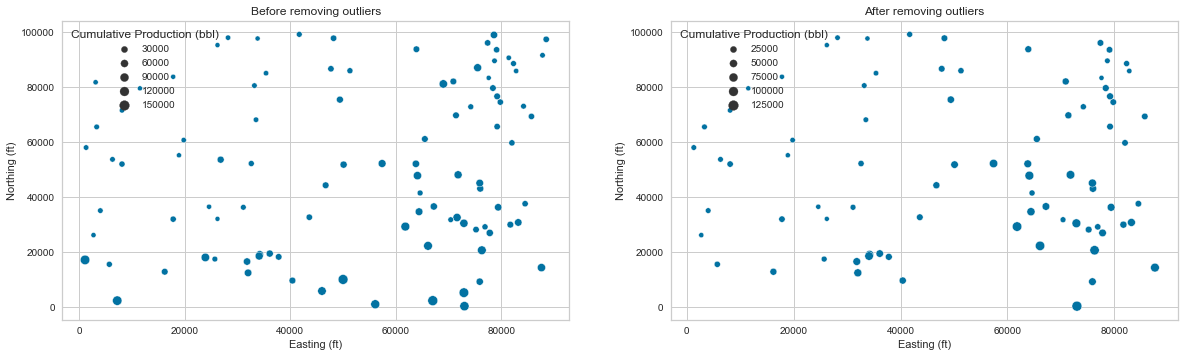

In [21]:
fig, ax = plt.subplots(1, 2)

fig.set_figwidth(20)

before_cleaning = clean_dataset(data.drop("Name", axis=1))

sns.scatterplot(data=before_cleaning, x="easting", y="northing", size="Cumulative Production (bbl)", ax=ax[0])
sns.scatterplot(data=clean_data, x="easting", y="northing", size="Cumulative Production (bbl)", ax=ax[1])

ax[0].set(xlabel="Easting (ft)", ylabel="Northing (ft)", title="Before removing outliers")
ax[1].set(xlabel="Easting (ft)", ylabel="Northing (ft)", title="After removing outliers")

After cleaning our data, we will use all but the easting and northing values from our dataframe to predict our cumulative production for each well. Originally we were using all of our data, but had to change our process due to issues with compounded error. 

#### Find the Important Features
Below is a helper function to show feature importances

In [22]:
def feature_importances(model, features_df, thresh=0.1):
    print("  Feature".ljust(36) + "  Score")
    print("-"*60)
    for i, feature in enumerate(model.feature_importances_):
        if abs(feature) >= thresh:
            print("| ", end="")
            print(f"{features_df.columns[i]}".ljust(36), end="|")
            print(f"{feature}".ljust(20), end="")
            print(" |")
            print("-"*60)

Below is a helper function to graph the accuracy of our regressor. It is worth mentioning that the accuracies will be different depending on what operating system you are running this notebook on due to differences in how the sklearn package performs random computations on different values. More details on this phenomenon can be found here: [documentation](https://github.com/lmcinnes/umap/issues/153) . We had better scores on linux than Windows in our case. 

In [23]:
def graph_acuracy(x, y, data, model, feature):
    plt.scatter(x[feature], rf.predict(x), label="Prediction")
    plt.scatter(x[feature], y, label="Acutal")
    plt.xlabel(f"{feature} value")
    plt.ylabel("Cumulative production")
    plt.legend()

Below is a helper method to graph the importances of different features to our regressor

In [24]:
def graph_importances(x, y, model, data, importances, thresh=0.1):
    for i, feature in enumerate(importances):
        if abs(feature) >= thresh:
            feat_name = x.columns[i]
            graph_acuracy(x, y, data, model, feat_name)
            plt.title(f"Acuracy of {feat_name} - Importance {feature}")
            plt.show()

Below is a function that will auto-fit and show a residual for our plot models

In [25]:
def show_residusal(model, train_tup, test_tup):
    resPlot = ResidualsPlot(model)
    resPlot.fit(*train_tup)
    resPlot.score(*test_tup)
    resPlot.show()

Here we dropped all of the columns that were not features which helped our regressors predict cumulative_output. This was much more relevant to our first method than our second, however, we decided to leave it in just in case we found a way to eliminate compounded error. 

In [26]:
%%capture
drop_columns = ['cum_production', 'cum_production_other', 'lifetime_hyp', 'lifetime_exp','frac stages', "well length", "oil saturation", 'pump rate (cubic feet/min)', 'proppant weight (lbs)']
clean_data.drop(drop_columns, axis=1)

The code below is what sets the x and values we will use for our regression models. After we switched from our first method, x only contained easting and northing. We take the log of cumulative production to hopefully linearize it and give our regressors and easier time. 

In [27]:
x = clean_data[["easting", "northing"]]
y = np.log(clean_data['cum_production']) 

Next, we perform a train_test_split on our data, so that we have a way to test our regressors. 

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=86)
train, test = (x_train, y_train), (x_test, y_test)

Since we potentially linearlize our data, we try a BaggingRegressor
with a base linear regression.

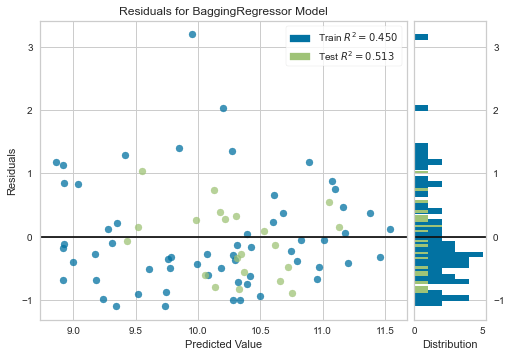

In [29]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
bag = BaggingRegressor(base_estimator=LinearRegression())
show_residusal(bag, train, test)

Both for the sake of using a regressor with feature_importances and trying to improve on our BaggingRegressor we tried using a RandomForestRegressor. 

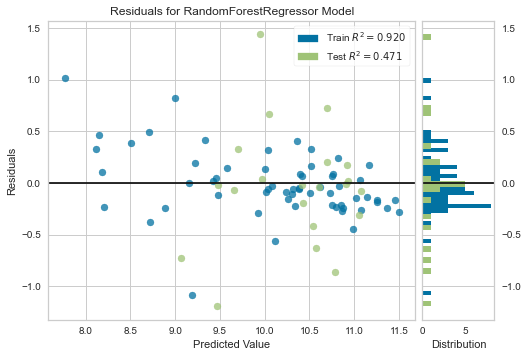

In [30]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=11,  random_state=86)
show_residusal(rf, train, test)

Here we check the feature importances of our RandomForestRegressor

In [31]:
feature_importances(rf, x, 0.1)

  Feature                             Score
------------------------------------------------------------
| easting                             |0.611682717817779    |
------------------------------------------------------------
| northing                            |0.388317282182221    |
------------------------------------------------------------


Next, we check how these features correlate to production

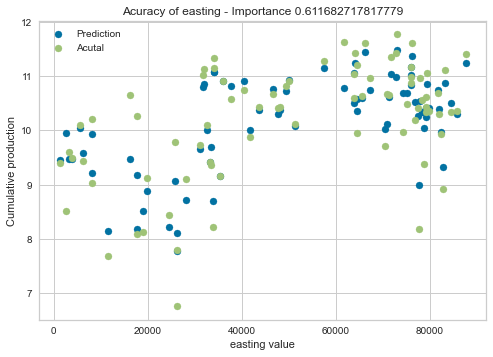

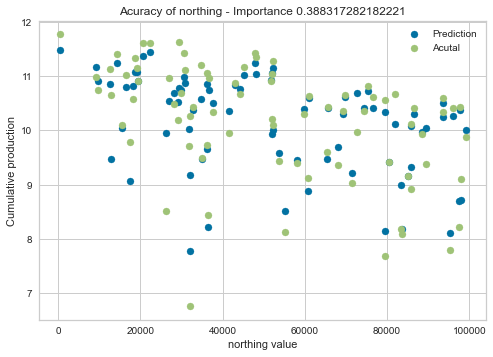

In [32]:
graph_importances(x, y, rf, data, rf.feature_importances_)

Since a RandomForestRegressor seemed to yield okay results, lets try an extra trees regressor. We ended up deciding to use this, because we found a score of roughly 0.6 to be acceptable. 

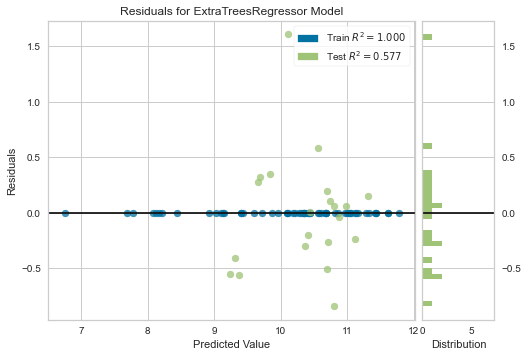

In [33]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(random_state=86)
show_residusal(etr, train, test)

Here, we graph the importances of our ET Regressor

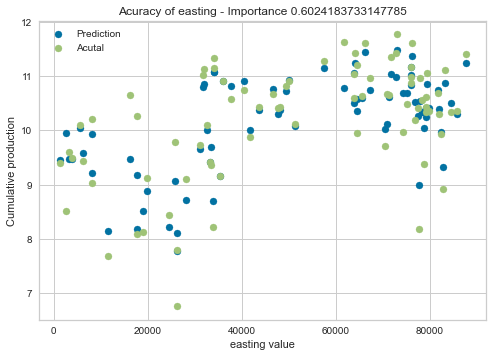

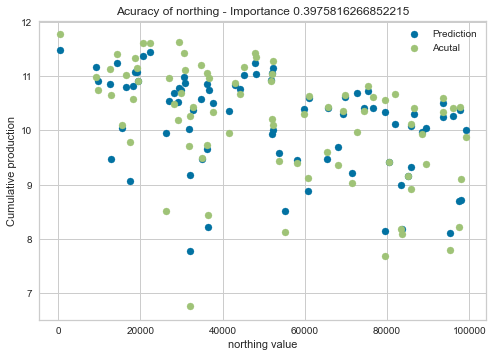

In [34]:
graph_importances(x, y, etr, data, etr.feature_importances_)

Here we list the feature importances of ET Regressor

In [35]:
feature_importances(etr, x, thresh=0)

  Feature                             Score
------------------------------------------------------------
| easting                             |0.6024183733147785   |
------------------------------------------------------------
| northing                            |0.3975816266852215   |
------------------------------------------------------------


The function below is leftover from our first attempt. We were using it to create regressors that predicted rock properties at different locations in the basin, so we could add them to our database. This was also at the core of why our first attempt failed. Given more time, we think that we could potentially fix our first method by applying multi-step-modeling techniques to this function. 

In [36]:
def create_regressor(data:pd.DataFrame, x_names: list, y_name:str):
    ds = clean_dataset(data)
    x = ds[x_names]
    y = ds[y_name]
    
    rf = ExtraTreesRegressor(random_state=86)
    rf.fit(*train)
    return rf

# Stage 3: Creating Permuations to save to our database (our first attempt)

### This code is really only relevant to our first method, however, we decided to leave it in the notebook as documentation for what we tried to do. 

#### Importances
We found that well length and frac stages did very little to optimize for production
therfore we will use the average of each from our data we removed these to speed up
our iterations, despite possibly losing some good locations/ drilling strageies.

This would help us to find as much variablity in a in ammount of reasonable time with a budge of ~10 hrs
because our machines lacked the amount of ram to iterate through this. We incorporated SQLlite3 to conserve
our memory usage.

Based off our ExtraTrees regressor's feature importances we decided to tier how important these values are

Tier 1
- pr  - pump rate **Iterated** 44 iteations
- ppf - proppant per stage **Iterated** 44 iterations

Tier 2
- easting **Iterated** 40 iterations
- perm **Predicted**

Tier 3
- northing **Iterated** 25 iterations

We imported a package called tqdm which created progress_bars that allowed us to see how long our iterations were taking

In [37]:
from tqdm.notebook import tqdm

Here we create the regressors for the values we need to predict using northing and easting. To make this work, x needs to be reset back to what we were using for our first attempt. 

In [38]:
x = clean_data.drop(drop_columns, axis = 1)
vals = ["easting","ppf", "pr", "northing"]
dicto = {}
optim = ["cum_production"]

for var in optim:
    reg = create_regressor(big_df.drop("Name", axis=1), ["easting", "northing"], var)
    dicto[var] = reg

This function took in the parameter we wanted to create permuations and how many permutations we wanted, then returned an array with the desired amount of permuations. 

In [39]:
special_ranges = ["northing", "easting"]
def iterate_over(df, var_name, number=1000):
    min_ = min(df[var_name])
    max_ = max(df[var_name])

    step = ((max_ - min_) / number)
    if var_name in special_ranges:
        return tqdm( np.arange(min_, max_, step), desc=var_name)
    else: 
        return np.arange(min_, max_, step)

The below code was needed to create an SQLite database and table within that database. It is commented out so as to not actually create a new database. To see how this fully works, run the create_database.py file from the following repo: [github repo](https://github.com/kmkhami/Create-SQLite-db)

In [40]:
#import sqlite3
#conn = sqlite3.connect("testFour.db")

#c = conn.cursor()
schema = """
CREATE TABLE biggest_poppa_table (
    porosity FLOAT(20),
    permeability FLOAT(20),
    Poissonzsratio FLOAT(20),
    YoungzsModulus FLOAT(20),
    watersaturation FLOAT(20),
    pr FLOAT(20),
    northing FLOAT(20),
    ppf FLOAT(20),
    easting FLOAT(20)
);
"""
#c.execute(schema)


Here we wrote a function that created all of our Northing and Easting permutations then predicted the rock properties for that location and assigned them to a dictionary

In [41]:
def iter_constants():
    for north in iterate_over(big_df, "northing", number=25):
        for east in iterate_over(big_df, "easting", number=40):
            values = {}
            values["easting"] = east
            values["northing"] = north
            values["pr"] = 0.0
            values["ppf"] = 0.0
            values["permeability"] = 0.0

            for key in dicto.keys():
                into_key = key.replace("'", "z").replace(" ", "")
                arr = np.array([north, east]).reshape(1, -1)
                values[into_key] = float( "{:20f}".format( dicto[key].predict(arr)[0] ) )
            yield copy.deepcopy(values)

Here we wrote a function that created our ppf and pr permutations and created a dictionary with all the values needed for a row of data in the table. 

In [42]:
def iter_hypers():
    c = conn.cursor()
    result = c.execute("SELECT rowid from biggest_poppa_table")

    for tup in tqdm(result.fetchall(), desc="Row"):
        rowid = tup[0]
        for prop in tqdm(iterate_over(big_df, "ppf", number=44), desc="ppf"):
            for pump in iterate_over(big_df, "pr", number=44):
                # Predict Our previous values
                values = addAllParams(rowid)

                values["pr"] = pump
                values["ppf"] = prop
                yield copy.deepcopy(values)

Here we wrote a function that created a dictionary to insert into the biggest_poppa_table. 

In [43]:
def addAllParams(rowid):
    values = {}
    c = conn.cursor()
    result = c.execute("SELECT * from biggest_poppa_table WHERE rowid= :rowid", {"rowid": rowid})
    tup = result.fetchall()
    por, perm, Poiss, Young, water, pr, north, ppf, east = tup[0]

    values["porosity"] = por
    values["permeability"] = perm
    values["Poisson's ratio"] = Poiss
    values["Young's Modulus"] = Young
    values["water saturation"] = water
    values["northing"] = north
    values["easting"] = east
    values["rowid"] = rowid

    return values

The following functions actually execute our SQLite command to update the table/database

In [44]:
lines_to_add_first_pass = """(:porosity, :permeability, :Poissonzsratio, :YoungzsModulus, :watersaturation, :pr, :northing, :ppf, :easting)"""

def f(x:dict):
    c = conn.cursor()
    c.execute(f"""INSERT into biggest_poppa_table VALUES {lines_to_add_first_pass}""", x)
    conn.commit()

def finish(x:dict):
    with conn:
        update_task(conn, x)

def update_task(conn, dictonary):
  values = {}
  for key in dictonary.keys():
    into_key = key.replace("'", "z").replace(" ", "")
    values[into_key] = dictonary[key]

  values["YoungzsModulus"] = dictonary["Young's Modulus"]

  sql = f'''INSERT into biggest_poppa_table VALUES {lines_to_add_first_pass}'''

  cur = conn.cursor()
  cur.execute(sql, values)
  conn.commit()

Lastly, we call all of the previous functions to create our database and table. The requests.get call is something we added so that Denzell would get a call when the iterations finished since we were running this code mostly overnight. It has been commented out, because it does not run correctly inside of a notebook. 

A repo with the necessarry files to create the SQLite database can be found here: [github repo](https://github.com/kmkhami/Create-SQLite-db) . All of the above code is located in the create_database.py file in that repo in such a fashion that it runs properly.  

In [45]:
#try:
#   list(map(f, iter_constants()))
#except Exception as e:
#    raise e
#finally:
#    pass

#try:
#    list(map(finish , iter_hypers()))
#finally:
#    conn.close()

#requests.get("https://emergencycontact.herokuapp.com/call/2144028404")

# Stage 4: Attempt Two 

### Our second attempt was very similar to our first, except we only use the northing and easting permutations. 

First, we load in the data from our generated database and create a dataframe called 'usable_data' from it. You can download the database here: [database.db](https://drive.google.com/file/d/1jIJxnT7c9emIw6_YCJbt1bCB6iahq5Wa/view?usp=sharing)

In [46]:
con = sqlite3.connect("database.db")
first_iteration = pd.read_sql_query("SELECT * from biggest_poppa_table", con)
con.close()
usable_data = first_iteration

Here we exponentially increase the cumulative production values from the database, because they are the predicted ln values. 

In [47]:
x = usable_data[["northing", "easting"]]
usable_data["cum_production"] = np.exp(rf.predict(x) )

Here we find the top 100 cumulative production values and add them to a new dataframe. We then add columns to the new dataframe to make it more readable. 

In [48]:
largest = usable_data.drop_duplicates(subset=["northing", "easting"]).nlargest(100, "cum_production")
largest["cumulative production"] = largest["cum_production"]
largest["cumulative production (bbl)"] = largest["cum_production"]

Following that, we graph the top 100 values. These will be different depending on what operating system you are running this notebook on due to differences in how the sklearn package performs random computations on different values. More details on this phenomenon can be found here: [documentation](https://github.com/lmcinnes/umap/issues/153)

Text(0, 0.5, 'Northing (ft)')

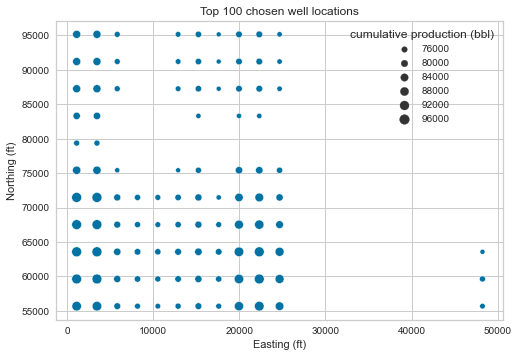

In [49]:
sns.scatterplot(data=largest, x="easting", y="northing", size="cumulative production (bbl)")
plt.title("Top 100 chosen well locations")
plt.xlabel("Easting (ft)")
plt.ylabel("Northing (ft)")

Next, we printed the top 40 values and chose the best wells that were 2000 ft. or more apart from another. 

In [50]:
largest[(largest["cum_production"] < 80_000)].head(40)

,porosity,permeability,Poissonzsratio,YoungzsModulus,watersaturation,pr,northing,ppf,easting,cum_production,cumulative production,cumulative production (bbl)
889,0.0734,0.02488,0.32803,8.877901e+06,0.244286,0.0,87256.0,0.0,22315.025,79866.552524,79866.552524,79866.552524
929,0.0608,0.01961,0.32941,8.938397e+06,0.255594,0.0,91204.0,0.0,22315.025,79866.552524,79866.552524,79866.552524
969,0.0592,0.01418,0.32941,8.914884e+06,0.262472,0.0,95152.0,0.0,22315.025,79866.552524,79866.552524,79866.552524
647,0.0960,0.04087,0.32769,1.022363e+07,0.098116,0.0,63568.0,0.0,17600.575,79588.931401,79588.931401,79588.931401
888,0.0797,0.03006,0.32686,8.856037e+06,0.240110,0.0,87256.0,0.0,19957.800,79526.731172,79526.731172,79526.731172
928,0.0608,0.01922,0.32905,8.790808e+06,0.251325,0.0,91204.0,0.0,19957.800,79526.731172,79526.731172,79526.731172
968,0.0593,0.01380,0.32905,8.786008e+06,0.259120,0.0,95152.0,0.0,19957.800,79526.731172,79526.731172,79526.731172
643,0.1005,0.04507,0.33618,1.038819e+07,0.105894,0.0,63568.0,0.0,8171.675,79490.152589,79490.152589,79490.152589
605,0.0817,0.02870,0.34980,1.048514e+07,0.062632,0.0,59620.0,0.0,12886.125,79282.070167,79282.070167,79282.070167
886,0.0835,0.03066,0.32800,8.165562e+06,0.240110,0.0,87256.0,0.0,15243.350,78765.338193,78765.338193,78765.338193


### These were the locations of the wells we chose

(east, north)
1. 601 - (3457 x 59620)
2. 721 - (3457 x 71464)
3. 881 - (3457 x 87256)
4. 921 - (3457 x 91204)
5. 961 - (3457 x 95152)
6. 521 - (3457 x 51724)
7. 642 - (5814 x 63568)
8. 604 - (10528 x 59620)
9. 682 - (5814 x 67516)
10. 923 - (8171 x 87256)

You may notice that two of the locations are commented out. This is because of the issue with the random kernel on different operating systems. Those two wells were not present in the top 100 on Windows while they were on Linux. 

Text(0, 0.5, 'Northing (ft)')

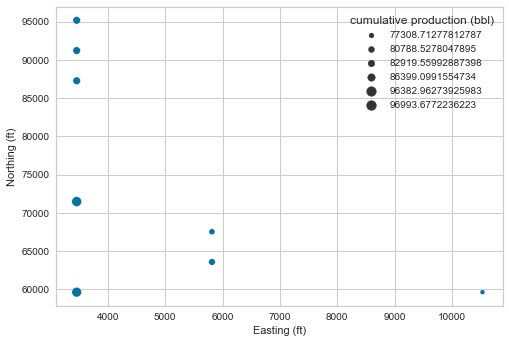

In [51]:
wells_chose = [601, 721, 881, 921, 961, 642, 604, 682] #521, 923
chosen_df = largest.loc[wells_chose]

sns.scatterplot(data=chosen_df, x="easting", y="northing", size="cumulative production (bbl)")
plt.xlabel("Easting (ft)")
plt.ylabel("Northing (ft)")

Here we create a scatterplot to show why we chose 50 stages for each of our 10 wells. It is worth mentioning that we did not choose 100 since we removed those values due to them being outliers and skewing the data. The vertical line represents the value we chose. 50 frac stages yielded a higher cumulative production than any other number on average, thus we decided to use this value for our wells. 

Text(0.5, 0, 'Frac Stages')

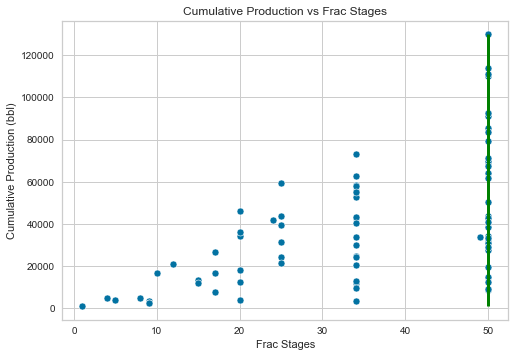

In [52]:
sns.scatterplot(data=clean_data, x="frac stages", y="cum_production")
plt.title("Cumulative Production vs Frac Stages")
plt.vlines(50, min(clean_data["cum_production"]), max(clean_data["cum_production"]), colors=["green"], linewidth=3)
plt.ylabel("Cumulative Production (bbl)")
plt.xlabel("Frac Stages")

Here we create a scatterplot to show how we chose 399 as the starting pump rate for each of our 10 wells. The vertical line represents the value we chose. The model we created to decide our 10 wells did not end up taking pump rate into account due to the difficulties with compounding error. Thus, we simply chose the mean out of the given wells as the value for the 10 we picked. 

Text(0, 0.5, 'Cumulative Production (bbl)')

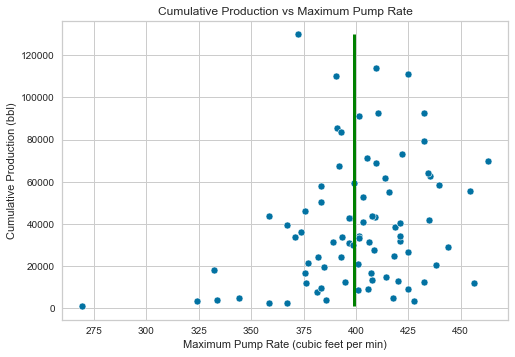

In [53]:
sns.scatterplot(data=clean_data, x="pr", y="cum_production")
plt.title("Cumulative Production vs Maximum Pump Rate")
plt.vlines(399, min(clean_data["cum_production"]), max(clean_data["cum_production"]), colors=["green"], linewidth=3)
plt.xlabel("Maximum Pump Rate (cubic feet per min)")
plt.ylabel("Cumulative Production (bbl)")

Here we create a scatterplot to show how we chose 1.38E+06 as the starting proppant per stage for each of our 10 wells. The vertical line represents the value we chose. The model we created to decide our 10 wells did not end up taking proppant per stage into account due to the difficulties with compounding error. Thus, we simply chose the mean out of the given wells as the value for the 10 we picked. 

Text(0, 0.5, 'Cumulative Production (bbl)')

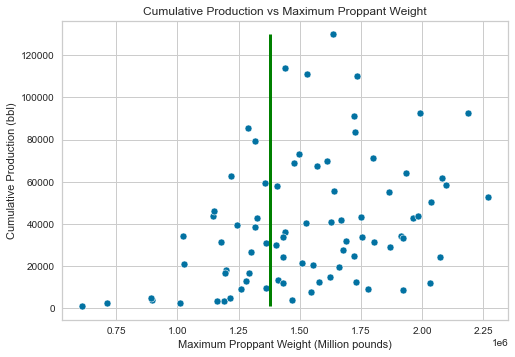

In [54]:
sns.scatterplot(data=clean_data, x="ppf", y="cum_production")
plt.title("Cumulative Production vs Maximum Proppant Weight")
plt.vlines(1.38*10**6, min(clean_data["cum_production"]), max(clean_data["cum_production"]), colors=["green"], linewidth=3)
plt.xlabel("Maximum Proppant Weight (Million pounds)")
plt.ylabel("Cumulative Production (bbl)")

Here we create a scatterplot to show how we chose 7800 as the well length for each of our 10 wells. The vertical line represents the value we chose. The model we created to decide our 10 wells did not end up taking well length into account due to the difficulties with compounding error. Thus, we simply chose the mean out of the given wells as the value for the 10 we picked. 

Text(0, 0.5, 'Cumulative Production (bbl)')

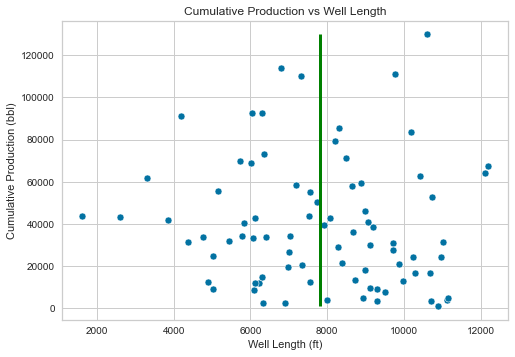

In [55]:
sns.scatterplot(data=clean_data, x="well length", y="cum_production")
plt.title("Cumulative Production vs Well Length")
plt.vlines(7800, min(clean_data["cum_production"]), max(clean_data["cum_production"]), colors=["green"], linewidth=3)
plt.xlabel("Well Length (ft)")
plt.ylabel("Cumulative Production (bbl)")

# Stage 5: Final Results

### Below is a table that represents the 10 wells we wanted to drill



![title](https://www.nicholaskhami.com/images/table.JPG)